In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F
import torchvision.transforms as transforms

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

import numpy as np
from utils import *

In [ ]:
## зададим некторорые настройки
class Args():
    batch_size = 4
    weight_decay = 0.0001
    print_every = 100


args = Args()

## Скачаем датасет

In [ ]:
# get CIFAR-10 data
transform_augment = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomCrop(32, padding=128)])
transform_normalize = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# dataloaders
cifar10_train = dset.CIFAR10('./dataset', train=True, download=True,
                                 transform=T.Compose([transform_augment, transform_normalize]))
loader_train = DataLoader(cifar10_train, batch_size=args.batch_size)
cifar10_val = dset.CIFAR10('./dataset', train=True, download=True,
                               transform=transform_normalize)
loader_val = DataLoader(cifar10_train, batch_size=args.batch_size)
cifar10_test = dset.CIFAR10('./dataset', train=False, download=True,
                                transform=transform_normalize)
loader_test = DataLoader(cifar10_test, batch_size=args.batch_size)

Extracting ./dataset/cifar-10-python.tar.gz to ./dataset
Files already downloaded and verified
Files already downloaded and verified


 ## Объявим модель

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ResNet(Block)
#model.load_state_dict(torch.load('ResNet18_weight'))
model.to(device)
criterion = nn.CrossEntropyLoss().cuda()

global gpu_dtype
gpu_dtype = torch.cuda.FloatTensor

In [ ]:
SCHEDULE_EPOCHS = [20, 20, 20, 10] # learning rate будет уменьшаться с каждым переходом 
learning_rate = 0.1

## Обучим

Starting epoch 20 / 20


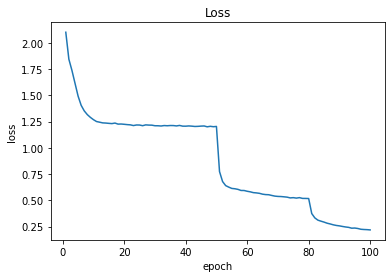

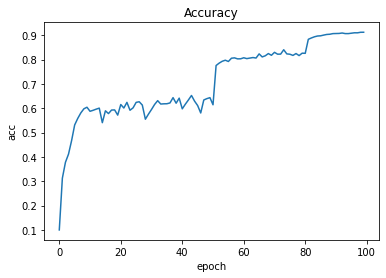

In [ ]:
from IPython import display


loss  = []
acc = []
for num_epochs in SCHEDULE_EPOCHS:
    print('Training for %d epochs with learning rate %f' % (num_epochs, learning_rate))
    optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                          momentum=0.9, weight_decay=args.weight_decay)
    for epoch in range(num_epochs):
        acc += [check_accuracy(model, loader_val)]  
        loss += [train(loader_train, model, criterion, optimizer)]
        display.clear_output()
        print('Starting epoch %d / %d' % (epoch+1, num_epochs))
        plot_loss_and_accuracy(loss, acc)        
        torch.save(model.cpu().state_dict(), 'ResNet18_weight')
        model.to(device)
    learning_rate *= 0.1

In [ ]:
print(f'final accuracy is {acc[-1]}')

final accuracy is 0.91258


In [ ]:
torch.save(model.state_dict(), 'resnet20.pth')

## Построим Roc кривую

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

In [ ]:
res , y_test = get_score(model, loader_test)
y_score = predict(model, loader_test)

In [ ]:
n_classes = 10
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()


true = np.zeros(y_score.shape)
for i in range(y_score.shape[0]):
    j = int(res[i])
    true[i][j] = 1
    
y_test = true.astype(int)    
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

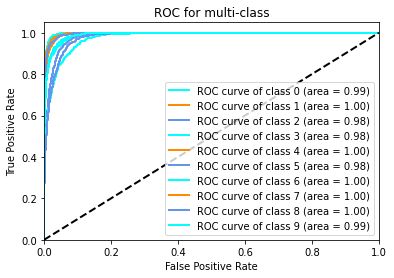

In [ ]:
# First aggregate all false positive rates
all_fpr = np.array([0.,1.,2.,3.,4.,5.,6.,7.,8.,9.])
lw = 2

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for multi-class')
plt.legend(loc="lower right")
plt.show()